## Number of games vs effect size

In this notebook we want to explore the correlation between number of games played by a country or played in a country versus the additional effect by soccer games.


In [1]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from tqdm.auto import tqdm
import os

sys.path.append("../")
sys.path.append("../covid19_inference")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
""" Matplotlib config
"""
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams["figure.figsize"] = [3.4, 2.7]  # APS single column
matplotlib.rcParams["figure.dpi"] = 300  # this primarily affects the size on screen
#matplotlib.rcParams['axes.linewidth'] = 0.3
matplotlib.rcParams["axes.labelcolor"] = "black"
matplotlib.rcParams["axes.edgecolor"] = "black"
matplotlib.rcParams["xtick.color"] = "black"
matplotlib.rcParams["ytick.color"] = "black"
matplotlib.rcParams["xtick.labelsize"] = 8
matplotlib.rcParams["ytick.labelsize"] = 8
matplotlib.rcParams["axes.labelsize"] = 8
matplotlib.rcParams["axes.titlesize"]= 10
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["legend.title_fontsize"] = 8

""" Colors
Done with rcParams / see plot.rcParams
"""


""" General configs
"""
fig_path = "./figures"
# Save figure as pdf and png        
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}

In [4]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

In [5]:
countries = [
    "England",
    "Scotland",
    "Germany",
    "France",
    "Spain",
    "Slovakia",
    "Portugal",
    "Netherlands",
    "Italy",
    #"Czechia",
    "Belgium",
    "Austria"]
tune = 1500
draws = 3000
max_treedepth = 12
traces, models, dls = [], [], []
for country in tqdm(countries):
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/jdehning/covid_uefa_traces11/"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-draw_delay=True"+
        f"-weighted_alpha_prior=0"+
        f"-prior_delay=-1"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.2"+
        f"-uc=True"+
        f"-len=normal"+
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pickled")
    if os.path.exists(fstr(tune, draws, max_treedepth)):
        model, trace = load(fstr(tune, draws, max_treedepth))
    elif os.path.exists(fstr(500, 1000, 12)) :
        print(f"Use short runs for {country}")
        model, trace = load(fstr(500, 1000, 12))
    else: 
        print(fstr(tune, draws, max_treedepth), " not found")
        continue      
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)

  0%|          | 0/11 [00:00<?, ?it/s]

In [6]:
n_games_by_team = []
n_games_in_country = []
effect = []
begin = datetime.datetime(2021, 6, 11)
end = datetime.datetime(2021, 7, 11)
for i, country in enumerate(countries):
    n_games_by_team.append((dls[i].alpha_prior[0,:] > 0).sum())
    n_games_in_country.append((dls[i].beta_prior > 0).sum())
    
    covid19_soccer.plot.other.get_alpha_infections(traces[i],models[i],dls[i])

    # Get params from trace and dataloader
    infections_base, infections_alpha = covid19_soccer.plot.other.get_alpha_infections(traces[i], models[i], dls[i])

    i_begin = (begin - model.sim_begin).days
    i_end = (end - model.sim_begin).days + 1  # inclusiv last day

    # Sum over the choosen range (i.e. month of uefa championship)
    num_infections_base = np.sum(infections_base[..., i_begin:i_end, :], axis=-2)
    num_infections_alpha = np.sum(infections_alpha[..., i_begin:i_end, :], axis=-2)

    # Create pandas dataframe for easy violin plot
    ratio_soccer = num_infections_alpha / (
        num_infections_base + num_infections_alpha
    )
    effect.append(ratio_soccer) # male [:,0] female [:,1]
effect = np.array(effect)

In [7]:
mean = effect.mean(axis=(-1,-2))
p025 = np.percentile(effect, 2.5,axis=(-1,-2))
p975 = np.percentile(effect,97.5,axis=(-1,-2))

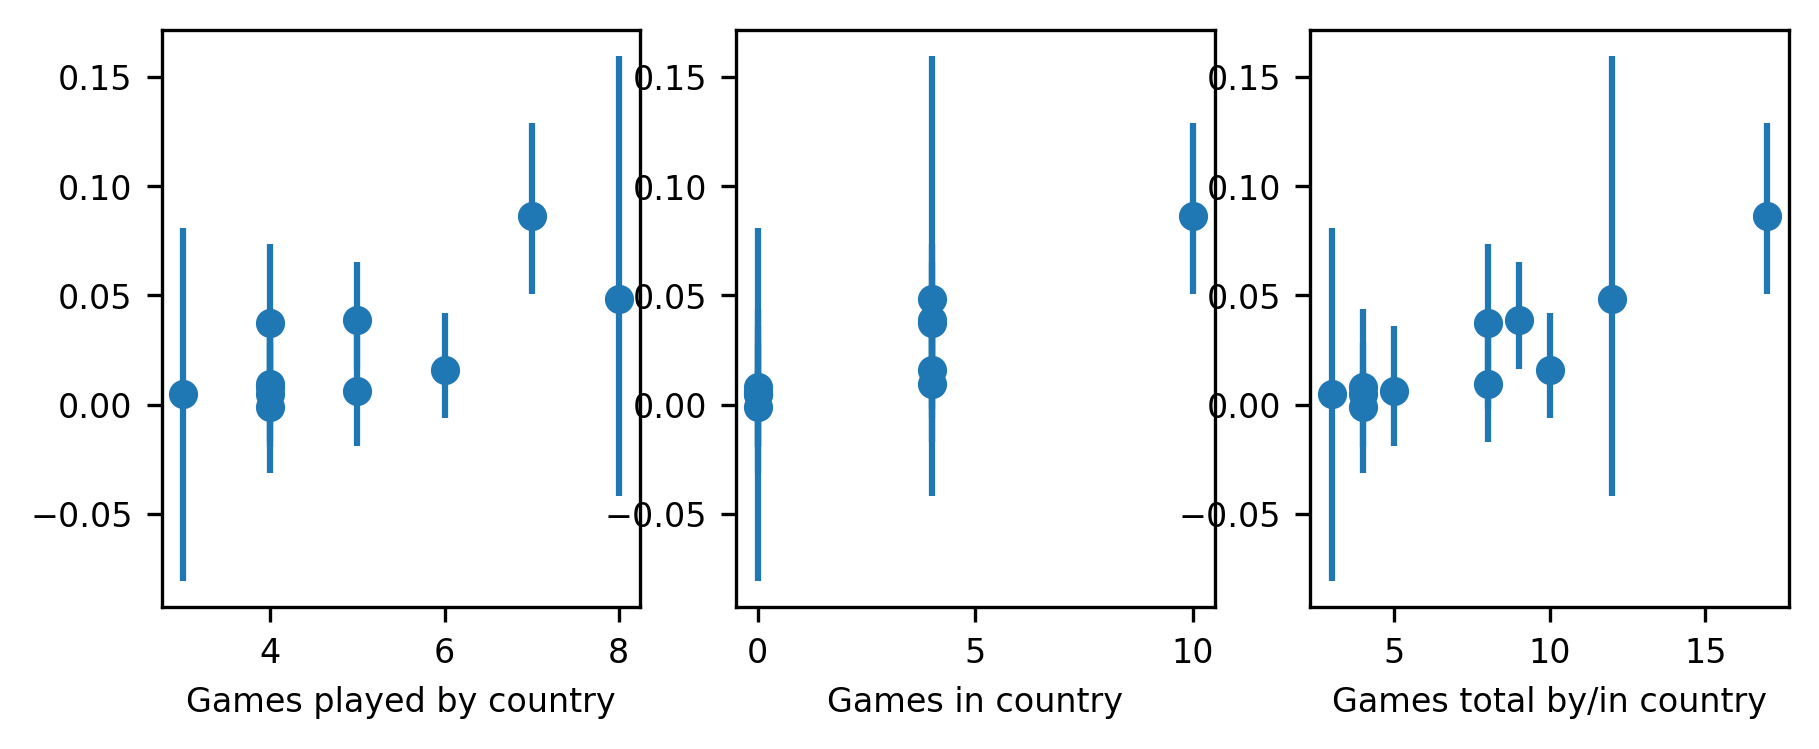

In [8]:
fig, axes = plt.subplots(1,3,figsize=(7,2.5))

axes[0].errorbar(
    n_games_by_team,
    mean,
    yerr=[mean - p025, p975 - mean],
    ls="",
    marker="o"
)
axes[0].set_xlabel("Games played by country")

axes[1].errorbar(
    n_games_in_country,
    mean,
    yerr=[mean - p025, p975 - mean],
    ls="",
    marker="o"
)
axes[1].set_xlabel("Games in country")


axes[2].errorbar(
    np.array(n_games_in_country)+np.array(n_games_by_team),
    mean,
    yerr=[mean - p025, p975 - mean],
    ls="",
    marker="o"
)
axes[2].set_xlabel("Games total by/in country")

plt.show()

In [ ]:
## Calculate stats

In [55]:
from statsmodels import api as sm
import statsmodels.formula.api as smf

# Construct dataset

X1 = np.stack([n_games_by_team]*24000,axis=-1).flatten()
X2 = np.stack([n_games_in_country]*24000,axis=-1).flatten()
Y = np.mean(effect,axis=-1).flatten()

data = pd.DataFrame(data=np.array([X1,X2,Y]).T,columns=["n_games_by_team","n_games_in_country","Effect"])

data["n_games_by_team"] = data["n_games_by_team"].astype(int)
data["n_games_in_country"] = data["n_games_in_country"].astype(int)
data["total"] = data["n_games_by_team"] + data["n_games_in_country"]
data

,n_games_by_team,n_games_in_country,Effect,total
0,7,10,0.077541,17
1,7,10,0.079230,17
2,7,10,0.077956,17
3,7,10,0.078587,17
4,7,10,0.071640,17
...,...,...,...,...
263995,4,0,-0.005614,4
263996,4,0,0.026517,4
263997,4,0,0.024077,4
263998,4,0,0.004129,4


In [56]:
model1 = smf.ols('Effect ~ n_games_by_team', data=data).fit()
p1 = model1.params

model2 = smf.ols('Effect ~ n_games_in_country', data=data).fit()
p2 = model2.params

model3 = smf.ols('Effect ~ total', data=data).fit()
p3 = model3.params

In [58]:
p3

Intercept   -0.020128
total        0.005731
dtype: float64

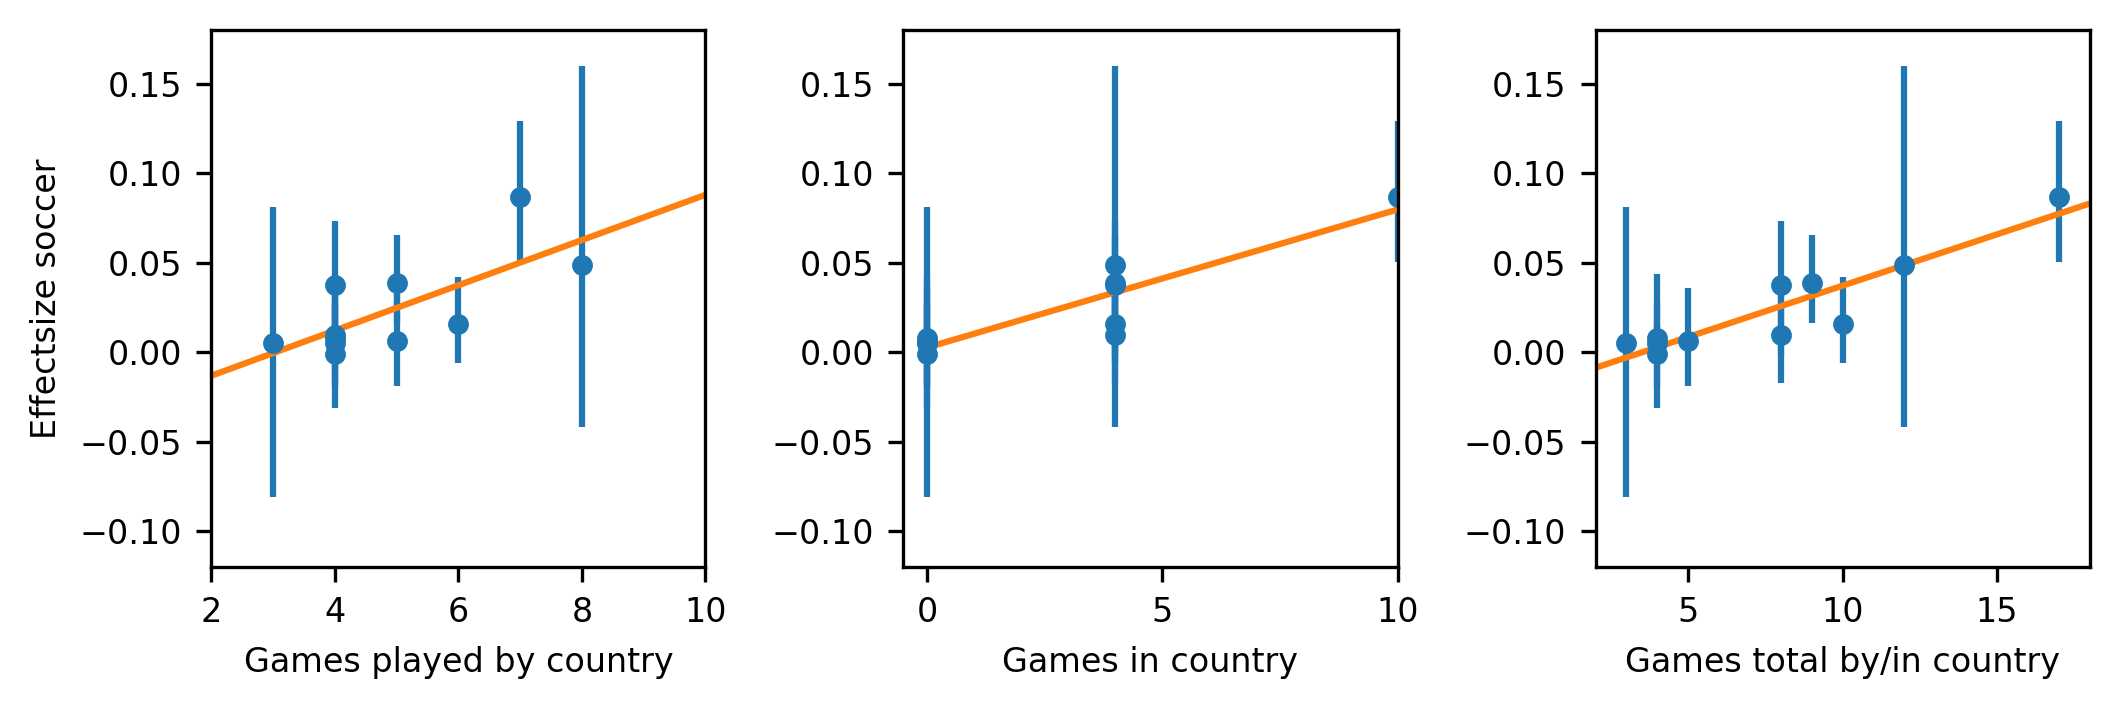

In [74]:
fig, axes = plt.subplots(1,3,figsize=(7,2.5))

x=np.arange(0,18,0.1)

axes[0].errorbar(
    n_games_by_team,
    mean,
    yerr=[mean - p025, p975 - mean],
    ls="",
    marker="o",
    ms=4
)
axes[0].plot(x,p1.Intercept+p1.n_games_by_team*x)
axes[0].set_xlabel("Games played by country")
axes[0].set_xlim(2,10)



axes[1].errorbar(
    n_games_in_country,
    mean,
    yerr=[mean - p025, p975 - mean],
    ls="",
    marker="o",
    ms=4
)
axes[1].plot(x,p2.Intercept+p2.n_games_in_country*x)
axes[1].set_xlabel("Games in country")
axes[1].set_xlim(-0.5,10)


axes[2].errorbar(
    np.array(n_games_in_country)+np.array(n_games_by_team),
    mean,
    yerr=[mean - p025, p975 - mean],
    ls="",
    marker="o",
    ms=4
)
axes[2].plot(x,p3.Intercept+p3.total*x)
axes[2].set_xlabel("Games total by/in country")
axes[2].set_xlim(2,18)
plt.tight_layout()

for ax in axes:
    ax.set_ylim(-0.12,0.18)

axes[0].set_ylabel("Effectsize soccer")

fig.savefig(f"{fig_path}/effect_vs_nGames.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/effect_vs_nGames.png", **save_kwargs)

plt.show()